In [124]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

##  Partie 1 : Echelle unique et inhibition

####  Calcul du Gradient avec un Noyau Gaussien

In [125]:
import numpy as np
from scipy.ndimage import convolve

def scale_dependent_gradient(image, sigma):
    # Fonction pour calculer le gradient à dépendance d'échelle
    # Création des noyaux gaussiens dérivés
    Gx, Gy = gaussian_derivative_kernels(sigma)
    
    # Convolution de l'image avec les noyaux dérivés
    F_sigma_x = convolve(image, Gx, mode='nearest')
    F_sigma_y = convolve(image, Gy, mode='nearest')
    
    # Calcul de la magnitude du gradient
    M_sigma = np.sqrt(F_sigma_x**2 + F_sigma_y**2)
    
    # Normalisation
    M_sigma /= np.max(M_sigma)
    
    return M_sigma

def gaussian_derivative_kernels(sigma):
    # Fonction pour créer les noyaux gaussiens dérivés
    # Taille du noyau (un multiple de sigma)
    sz = int(np.ceil(sigma * 3) * 2 + 1)
    
    # Création du noyau gaussien
    X, Y = np.meshgrid(np.arange(-sz/2, sz/2 + 1), np.arange(-sz/2, sz/2 + 1))
    G = np.exp(-(X**2 + Y**2) / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    
    # Dérivées du noyau gaussien
    Gx = -X * G / sigma**2
    Gy = -Y * G / sigma**2
    
    return Gx, Gy


In [126]:
def gradient_magnitude(gray_image, sigma=1.0):
    # Apply Gaussian smoothing
    blurred_image = cv2.GaussianBlur(gray_image, (0, 0), sigmaX=sigma)

    # Compute the x and y gradients using the Sobel operators
    gradient_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)

    # Compute the gradient magnitude
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # Normalize to [0, 1]
    gradient_magnitude /= np.max(gradient_magnitude)

    return gradient_magnitude


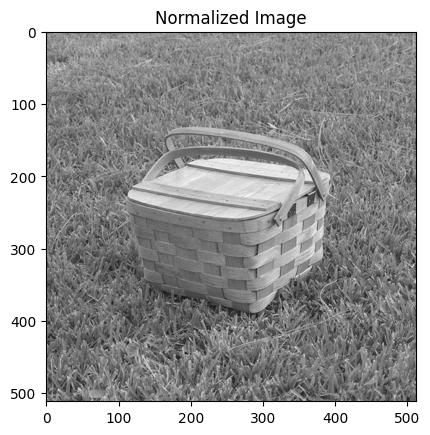

In [127]:
import cv2
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('database/images/basket.pgm', cv2.IMREAD_UNCHANGED)

if image is None:
    print("Error: Unable to read the image.")
else:
    # Convert to float
    image = image.astype(float)

    # Normalize the image values to be between 0 and 1
    image_normalized = (image - image.min()) / (image.max() - image.min())

    # Display the normalized image
    plt.imshow(image_normalized, cmap='gray')
    plt.title('Normalized Image')
    plt.show()


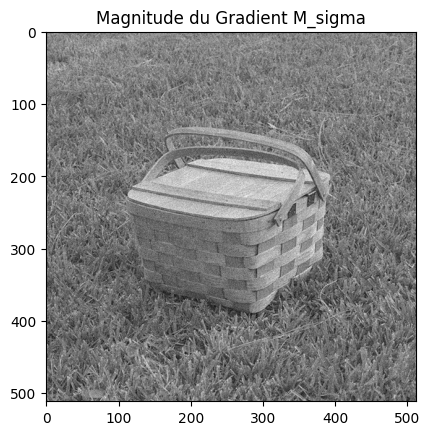

In [128]:
## adding noise to the image 

noise = np.random.normal(0, 1, image_normalized.shape)
image_noisy = (1-0.05)*image_normalized + 0.05*noise

plt.imshow(image_noisy, cmap='gray')
plt.title('Magnitude du Gradient M_sigma')
plt.show()

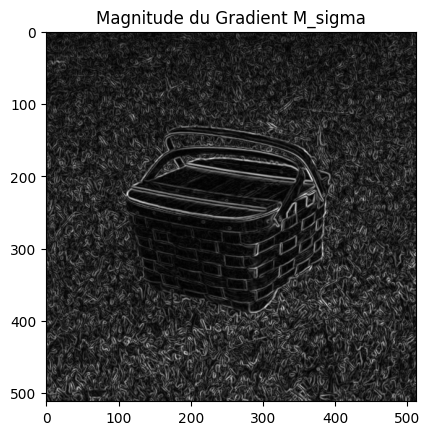

In [129]:
# Partie 1 : Echelle unique et inhibition
# Calcul du Gradient avec un Noyau Gaussien
# paramètre
sigma = 1

M_sigma = scale_dependent_gradient(image_normalized, sigma)

# Afficher le gradient
plt.imshow(M_sigma, cmap='gray')
plt.title('Magnitude du Gradient M_sigma')
plt.show()


In [130]:
min_M_sigma = np.min(M_sigma)
max_M_sigma = np.max(M_sigma)


print(min_M_sigma)
print(max_M_sigma)

0.00018009360745302
1.0


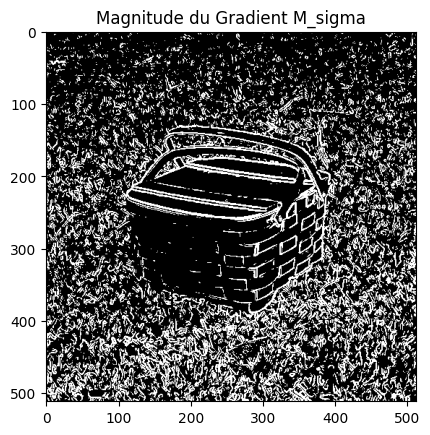

In [131]:
## select only vamues of M_sigma > 0.2 and plot the image in gray scale

M_sigma_seuil = np.zeros_like(M_sigma)

for i in range(M_sigma.shape[0]):
    for j in range(M_sigma.shape[1]):
        if M_sigma[i, j] > 0.2:
            M_sigma_seuil[i,j] = 1


plt.imshow(M_sigma_seuil, cmap='gray')
plt.title('Magnitude du Gradient M_sigma')
plt.show()

#### Inhibition des Contours Environnants

In [132]:


def difference_of_gaussians(sigma):
    # Taille du noyau (un multiple de sigma)
    sz = int(np.ceil(sigma * 3) * 2 + 1)
    
    # Création de la grille de coordonnées
    X, Y = np.meshgrid(np.arange(-sz/2, sz/2 + 1), np.arange(-sz/2, sz/2 + 1))
    
    # Calcul des deux gaussiennes
    G1 = np.exp(-(X**2 + Y**2) / (2 * (sigma * 4)**2))
    G2 = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    
    # Difference of Gaussians
    dog = np.maximum(G1 / (2 * np.pi * (sigma * 4)**2) - G2 / (2 * np.pi * sigma**2), 0)
    
    return dog

def normalization_term(sigma):
    # Calcul du DoG
    dog = difference_of_gaussians(sigma)
    
    # Calcul du terme de normalisation
    w_sigma = dog / np.sum(dog**2)
    
    return w_sigma

def suppression_term(M_sigma, sigma):
    # Calcul du DoG
    w_sigma = normalization_term(sigma)
    
    # Convolution du DoG avec la magnitude du gradient
    t_sigma = convolve(M_sigma, w_sigma, mode='nearest')
    
    return t_sigma

def contour_inhibition(M_sigma, sigma, alpha):
    # Calcul du terme de suppression
    t_sigma = suppression_term(M_sigma, sigma)
    
    # Supprimer les valeurs négatives
    t_sigma = np.maximum(t_sigma, 0)
    
    # Inhibition de contour
    c_sigma = M_sigma - alpha * t_sigma
    
    # Supprimer les valeurs négatives
    c_sigma = np.maximum(c_sigma, 0)
    
    return c_sigma


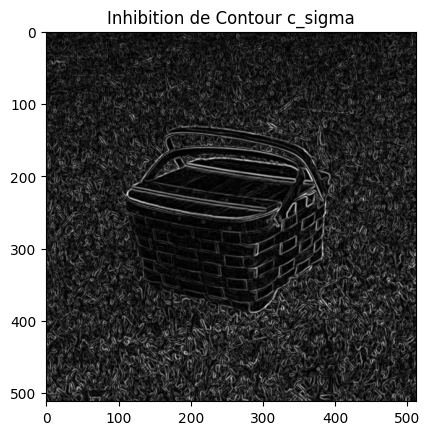

In [133]:
# paramètre
alpha = 0.001



c_sigma = contour_inhibition(M_sigma  , sigma , alpha)


# Afficher l'inhibition
plt.imshow(c_sigma, cmap='gray')
plt.title('Inhibition de Contour c_sigma')
plt.show()

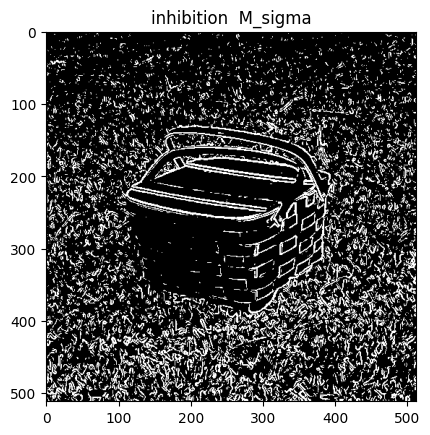

In [134]:
C_sigma_seuil = np.zeros_like(c_sigma)

for i in range(c_sigma.shape[0]):
    for j in range(c_sigma.shape[1]):
        if c_sigma[i, j] > 0.2:
            C_sigma_seuil[i,j] = 1


plt.imshow(C_sigma_seuil, cmap='gray')
plt.title('inhibition  M_sigma')
plt.show()

## Methode Rosin

In [135]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

def doubleRosinThr(originalImage, precission=0.01, gaussianSigma=3):
    # Validate Arguments
   
    assert (precission > 0), 'Error: Precision must be a positive value.'

    binsNumber = round(1 / precission)
    assert (binsNumber > 10), 'Error: Wrong (too coarse) precision.'

    assert (gaussianSigma >= 0), 'Error: GaussianSigma must be a non-negative value.'

    # Preprocessing
    originalImage = originalImage.astype(np.float64)
    if np.max(originalImage) > 1.001:
        factor = 255
        originalImage = originalImage / 255
    else:
        factor = 1

    ## show histogramme 
    # Afficher le résultat final
   

    # Processing: Histogram
    histogram, _ = np.histogram(originalImage.flatten(), bins=binsNumber)
    # Afficher le résultat final
    histogram[0] = histogram[1]
    # Plot the histogram
    plt.plot(histogram, color='gray')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()
    
    if gaussianSigma > 0:
        histogram = gaussian_filter1d(histogram.astype(float), gaussianSigma)


    plt.plot(histogram, color='gray')
    plt.xlabel('Pixel Value liss')
    plt.ylabel('Frequency')
    plt.show()

    
    # Processing: Finding the peak (histPeak)
    histPeak = np.argmax(histogram)

    # Handling single peak or multiple peaks
    if histogram[histPeak] < 0.10 * histogram[0]:
        histPeak = np.argmax(histogram)

    # Processing: Finding the max (histEnd)
    histEnd = len(histogram) - 1
    while histogram[histEnd] == 0 and histogram[histEnd - 1] == 0 and histEnd > 1:
        histEnd -= 1
    if histEnd == 1:
        raise ValueError('Error: The histogram was empty or the image was 0-valued.')

    # Processing: Finding the high THR
    highThr = histPeak + getMaxDist(histogram[histPeak:histEnd]) - 1

    # Processing: Finding the low THR
    lowThr = histPeak + getMaxDist(histogram[histPeak:highThr]) - 1

    # Output formatting
    perc = np.array([lowThr, highThr]) / binsNumber
    doubleThr = perc * factor

    return doubleThr


def getMaxDist(funcValues):
    x = 0
    y = len(funcValues) - 1

    hx = funcValues[x]
    hy = funcValues[y]

    # Checking if the denominator is zero to avoid division by zero
    if y - x == 0:
        return x

    # Defining the line
    a = (hy - hx) / (y - x)
    b = hx - (x * a)

    distances = np.zeros_like(funcValues)
    maxDistance = -1
    furthersPos = x

    for z in range(x, y + 1):
        hz = funcValues[z]
        dist = np.abs(a * z - hz + b) / np.sqrt(a ** 2 + 1)
        distances[z] = dist
        if dist > maxDistance:
            maxDistance = dist
            furthersPos = z

    return furthersPos


#### Seuillage par hystérésie et suppression des non-maxima

In [136]:
def get_neighbors(grad_angle, i, j):
    # Determine the neighbors based on the gradient angle

    # Convert angle to degrees
    angle1 = grad_angle * 180.0 / np.pi

    # Make sure the angle is positive
    angle1 = angle1 % 180

    # Quantize the angle to one of four directions: 0, 45, 90, 135 degrees
    quantized_angle = (round(angle1 / 45) * 45) % 180

    # Determine neighboring pixels based on the quantized angle
    if quantized_angle == 0:
        neighbors = [(i, j - 1), (i, j + 1)]
    elif quantized_angle == 45:
        neighbors = [(i - 1, j - 1), (i + 1, j + 1)]
    elif quantized_angle == 90:
        neighbors = [(i - 1, j), (i + 1, j)]
    elif quantized_angle == 135:
        neighbors = [(i - 1, j + 1), (i + 1, j - 1)]
    else:
        raise ValueError("Invalid quantized angle")

    return neighbors[0], neighbors[1]

In [137]:
from skimage import img_as_float

def find_neighbors(angle, i, j):
    neighb1 = (i, j)
    neighb2 = (i, j)
    # Détermination de la direction du gradient
    if (angle > -np.pi/8 and angle <= np.pi/8) or (angle > 7*np.pi/8 or angle <= -7*np.pi/8):
        neighb1 = (i, j+1); neighb2 = (i, j-1)

    elif (angle > np.pi/8 and angle <= 3*np.pi/8) or (angle > -7*np.pi/8 and angle <= -5*np.pi/8):
        neighb1 = (i-1, j+1); neighb2 = (i+1, j-1)
    elif (angle > 3*np.pi/8 and angle <= 5*np.pi/8) or (angle > -5*np.pi/8 and angle <= -3*np.pi/8):
        neighb1 = (i-1, j); neighb2 = (i+1, j)
    elif (angle > 5*np.pi/8 and angle <= 7*np.pi/8) or (angle > -3*np.pi/8 and angle <= -np.pi/8):
        neighb1 = (i-1, j-1); neighb2 = (i+1, j+1)
    
    return neighb1, neighb2

def supp_non_max(c_sigma):
    # Calcul du gradient
    Fx, Fy = np.gradient(img_as_float(c_sigma))
    angle =  np.pi/2 - np.arctan2(Fy, Fx)
    

    # Suppression des non-maximas
    non_max_suppressed = np.zeros_like(c_sigma)
    for i in range(0, angle.shape[0]-1):
        for j in range(0, angle.shape[1]-1):
            
            if  (angle[i,j] >= 3.14) :
                angle[i,j] = angle[i,j] - np.pi

            


            # Trouver les voisins dans la direction du gradient
            neighb1, neighb2 = get_neighbors(angle[i, j], i, j)
            
            # Suppression des non-maxima
            if c_sigma[i, j] >= c_sigma[neighb1] and c_sigma[i, j] >= c_sigma[neighb2]:
                non_max_suppressed[i, j] = c_sigma[i, j]

    seuils = doubleRosinThr(non_max_suppressed,0.01 , 3)            
    
    return non_max_suppressed , seuils

def seuil_hyst(c_sigma):
    # Suppression des non-maximas
    non_max_suppressed , s  = supp_non_max(c_sigma)

    seuil_bas = s[0]
    seuil_haut = s[1]
    
    b_sigma = np.zeros_like(c_sigma)
    b_sigma[non_max_suppressed >= seuil_haut] = 1
    
    # Propagation des pixels forts aux faibles
    for i in range(1, c_sigma.shape[0]-1):
        for j in range(1, c_sigma.shape[1]-1):
            if non_max_suppressed[i, j] >= seuil_bas:
                if np.any(b_sigma[i-1:i+2, j-1:j+2] == 1):
                    b_sigma[i, j] = 1
   

    
    return b_sigma 

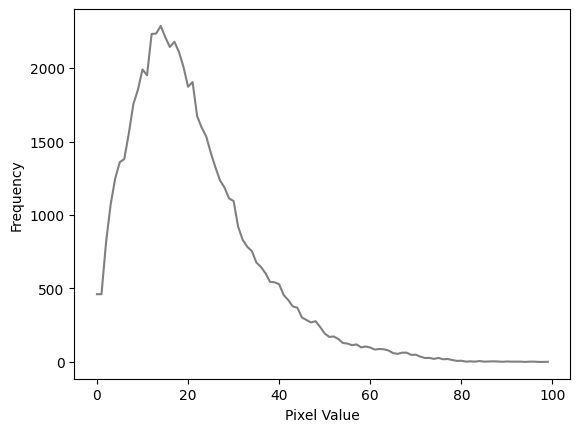

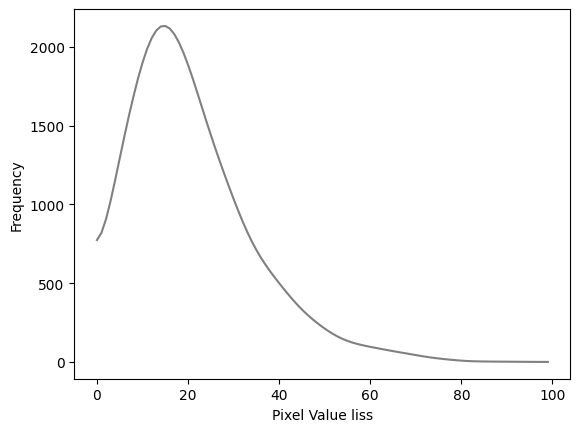

array([0.33, 0.46])

In [138]:
non_max ,s = supp_non_max(c_sigma)


s

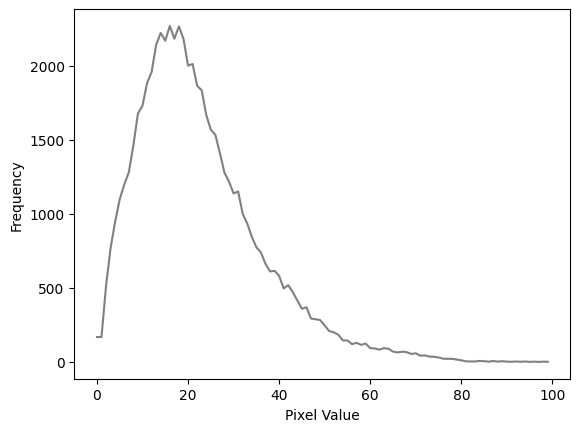

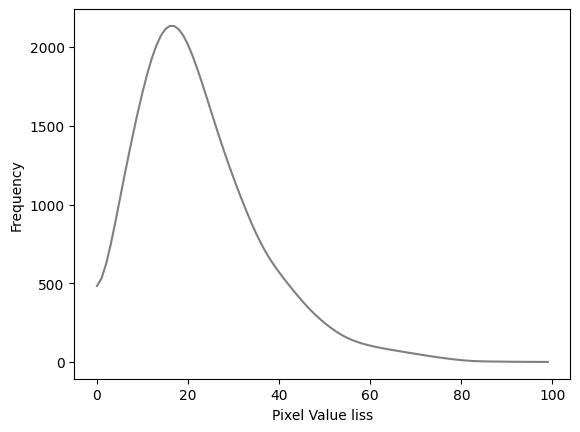

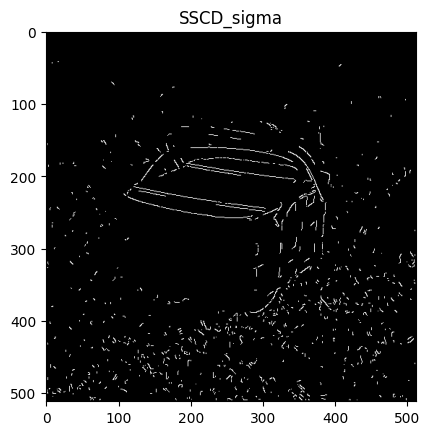

In [139]:

c_sigma2 = seuil_hyst(M_sigma)



# Afficher le résultat final
plt.imshow(c_sigma2, cmap='gray')
plt.title('SSCD_sigma')
plt.show()



## Partie 2 : Echelle multiple et Canny

In [140]:
def SingleScaleContourDetector(image , sigma , alpha):
    # Calcul du Gradient avec un Noyau Gaussien
    M_sigma = gradient_magnitude(image, sigma)
    # Afficher le résultat final
   
    c_sigma = contour_inhibition(M_sigma, sigma, alpha)
    

    ## normalise image 
    
    c_sigma_normal = (c_sigma- c_sigma.min()) / (c_sigma.max() - c_sigma.min())
    # Seuillage hystérésique et suppression des non-maxima
    # Afficher le résultat final
    c_non_max ,s = supp_non_max(c_sigma)
    
    print('--------')
    print(s[0]
          )
    print(s[1])
    
    SSCD = seuil_hyst(c_sigma_normal)
    
    return SSCD

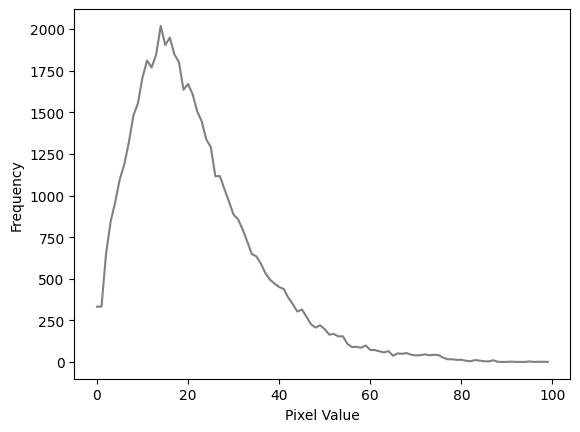

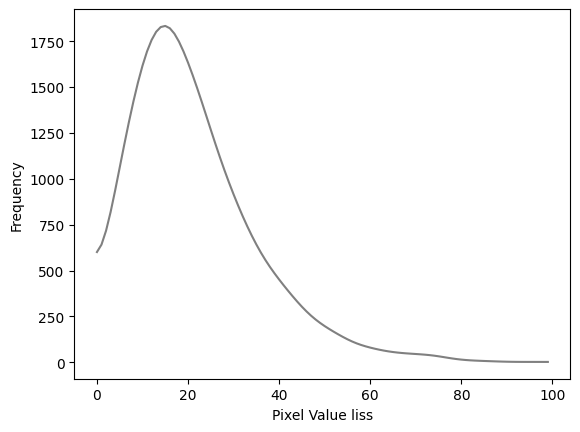

--------
0.33
0.46


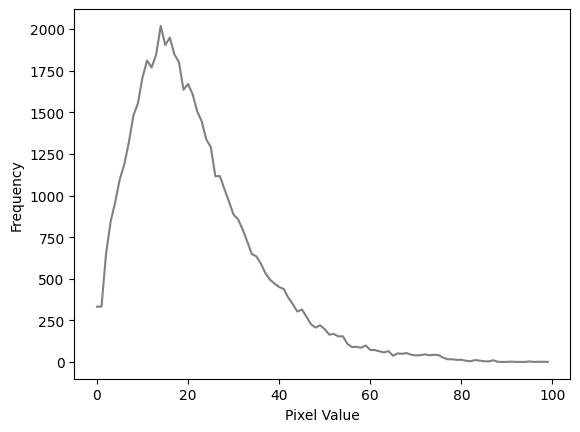

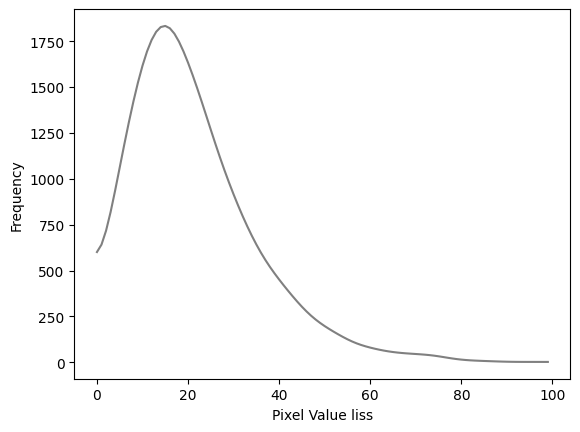

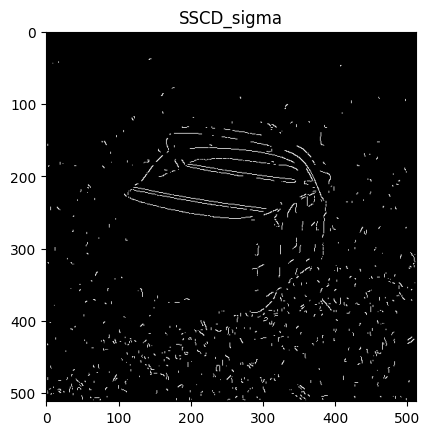

In [141]:
# Canny edge detection for sigma = 1
b1 = SingleScaleContourDetector(image_normalized , 1 ,alpha)

# Afficher le résultat final
plt.imshow(b1, cmap='gray')
plt.title('SSCD_sigma')
plt.show()

In [142]:
def dilat_morph(image):
    # Opérateur DTO
    rows, cols = np.where(image > 0)
    beta = np.zeros((image.shape[0] * 2, image.shape[1] * 2))
    beta[rows * 2, cols * 2] = 1
    
    # Dilatation morphologique
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))  # Use MORPH_ELLIPSE for a disk-shaped structuring element
    dto = cv2.dilate(beta.astype(np.uint8), se)
    
    return dto

In [143]:
import numpy as np
import numpy as np

def doubling_and_ticking_operator(binary_map):
    # Double the size of the input binary map
    doubled_coordinates = np.zeros((2 * binary_map.shape[0], 2 * binary_map.shape[1]), dtype=binary_map.dtype)
    doubled_coordinates[::2, ::2] = binary_map

    # Create an array to represent the disk of radius 3 pixels
    radius = 3
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    disk = x**2 + y**2 <= radius**2
    disk = disk.astype(binary_map.dtype)  # Ensure the disk array has the same data type as the binary_map

    # Initialize the result array with the same shape as the input binary map
    result = np.zeros_like(binary_map)

    # Substitute each nonzero pixel with the disk of radius 3 pixels
    for y_coord, row in enumerate(doubled_coordinates):
        for x_coord, value in enumerate(row):
            if value > 0:
                # Calculate the coordinates for assignment in the result array
                y_start = max(0, y_coord - radius)
                y_end = min(binary_map.shape[0], y_coord + radius + 1)
                x_start = max(0, x_coord - radius)
                x_end = min(binary_map.shape[1], x_coord + radius + 1)
                
                # Perform the assignment with proper slicing
                result[y_start:y_end, x_start:x_end] |= disk[
                    (y_coord - y_start):(y_coord - y_start) + (y_end - y_start),
                    (x_coord - x_start):(x_coord - x_start) + (x_end - x_start)
                ]

    return result



In [144]:
def decim_im(image, N):
    sigma = 2**N
    sz = int(np.ceil(sigma * 3) * 2 + 1)
    X, Y = np.meshgrid(np.arange(-sz/2, sz/2 + 1), np.arange(-sz/2, sz/2 + 1))
    G = np.exp(-(X**2 + Y**2) / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    im_convolu = convolve(image.astype(np.float32), G.astype(np.float32), mode='constant', cval=0.0)
    im_decimee = cv2.resize(im_convolu, None, fx=1/2**(N-1), fy=1/2**(N-1), interpolation=cv2.INTER_CUBIC).astype(np.float32)
    return im_decimee

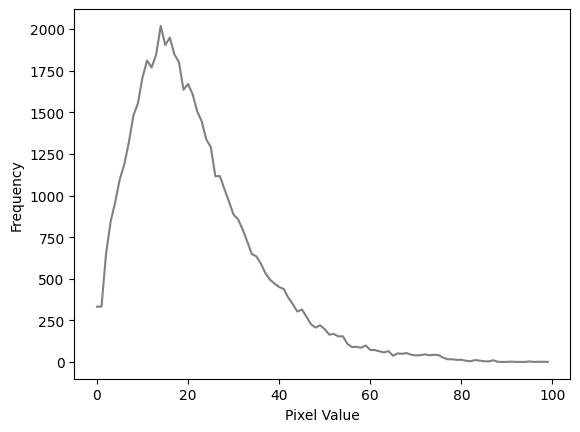

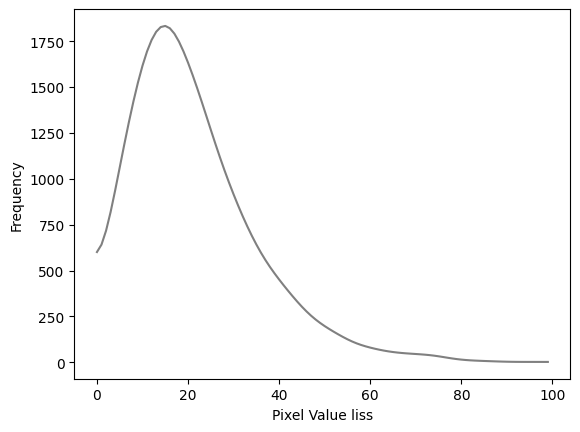

--------
0.33
0.46


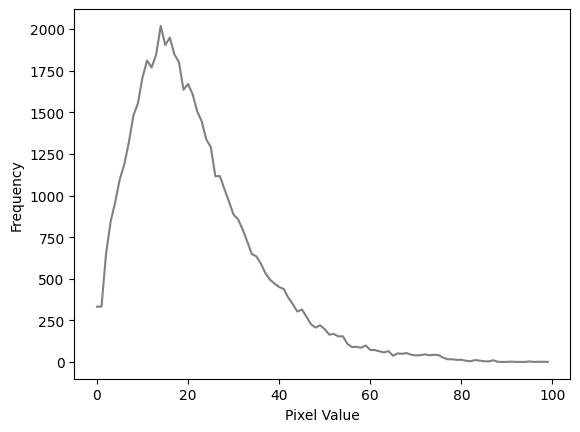

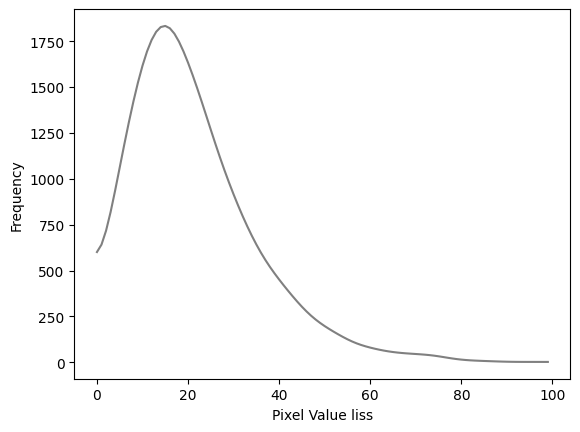

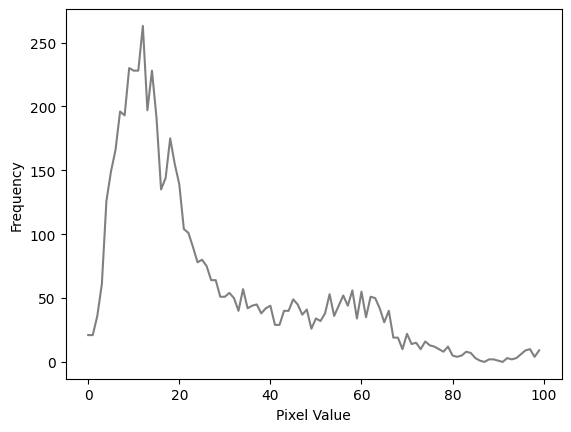

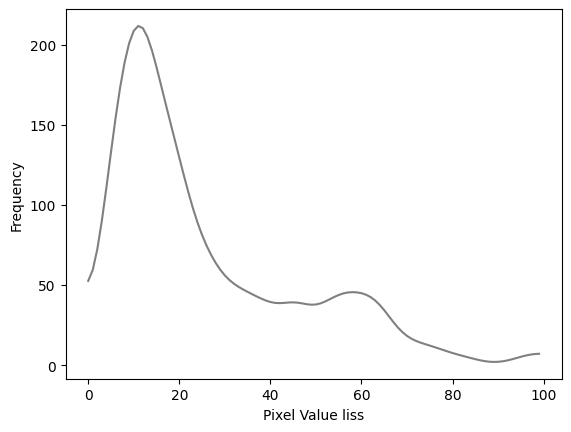

--------
0.23
0.3


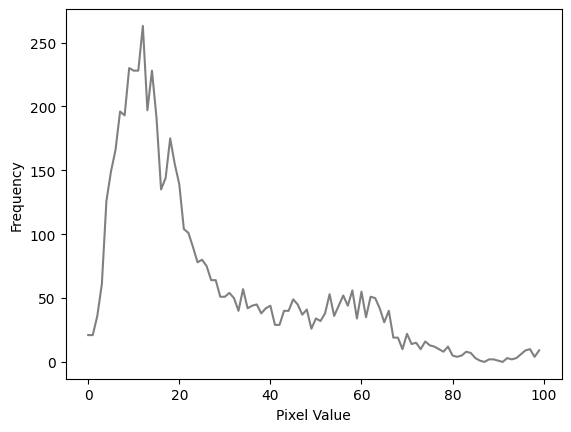

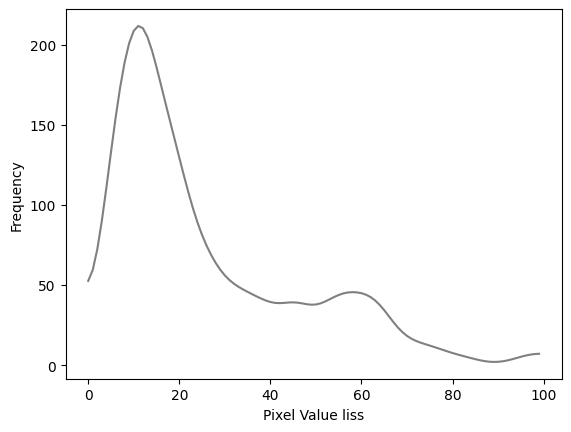

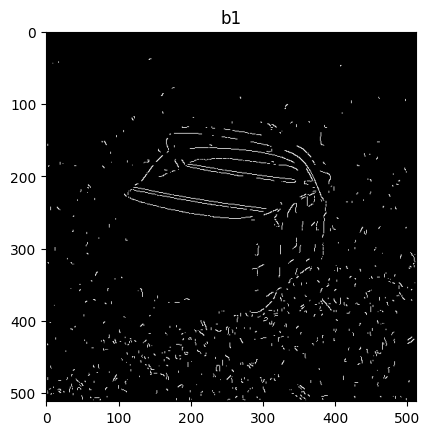

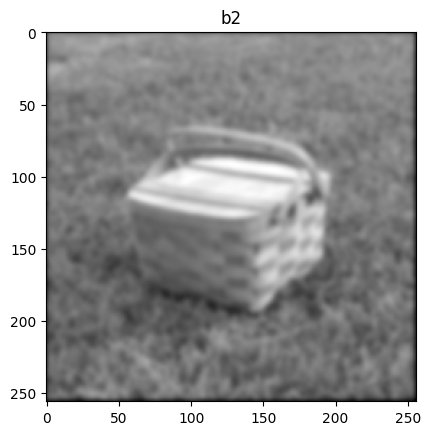

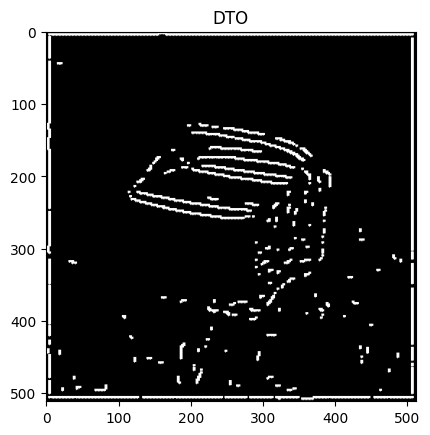

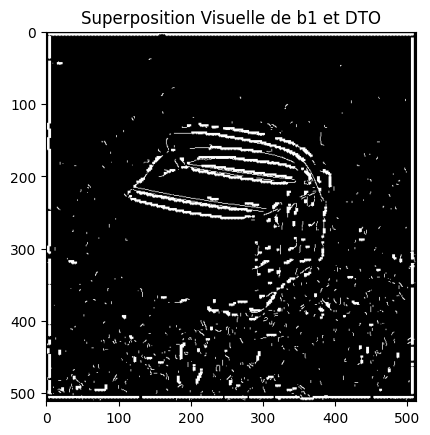

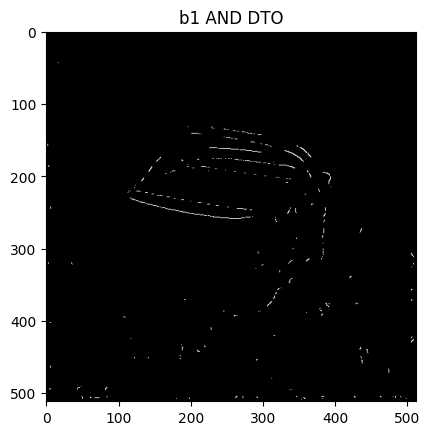

In [145]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Détection des Contours à l'Échelle Originale avec Canny sigma = 1 et 2
# Seuils à ajuster en fonction de l'image qu'on met en entrée

alpha = 0.001

# Canny edge detection for sigma = 1
b1 = SingleScaleContourDetector(image_normalized , 1 ,  alpha)
# Canny edge detection for sigma = 2
k = 2
b2_decimated = decim_im(image_normalized, k)

b2 = SingleScaleContourDetector(b2_decimated, 1 , alpha )

# Afficher les résultats
plt.imshow(b1, cmap='gray')
plt.title('b1')
plt.show()


plt.imshow(b2_decimated , cmap='gray')
plt.title('b2')
plt.show()

dto2 =dilat_morph(b2)

# Affichage du DTO
plt.imshow(dto2, cmap='gray')
plt.title('DTO')
plt.show()



# Convert b1 to the same data type as dto
b1 = b1.astype(np.uint8)

# Superposition visuelle de b1 et DTO
superposition_visuelle = cv2.bitwise_or(b1 , dto2)

plt.imshow(superposition_visuelle, cmap='gray')
plt.title('Superposition Visuelle de b1 et DTO')
plt.show()

# Opération logique AND entre b1 et DTO
b1_and_dto = cv2.bitwise_and(b1, dto2)

plt.imshow(b1_and_dto, cmap='gray')
plt.title('b1 AND DTO')
plt.show()


##  Partie 3 : Echelle multiple et inhibition

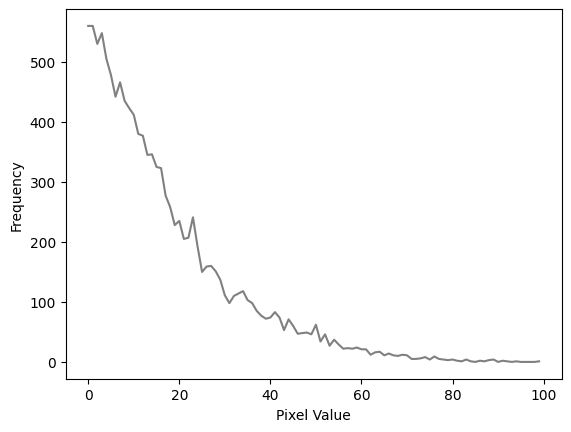

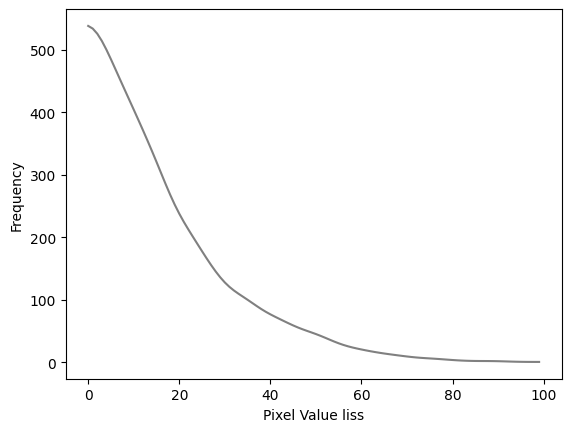

--------
0.19
0.31


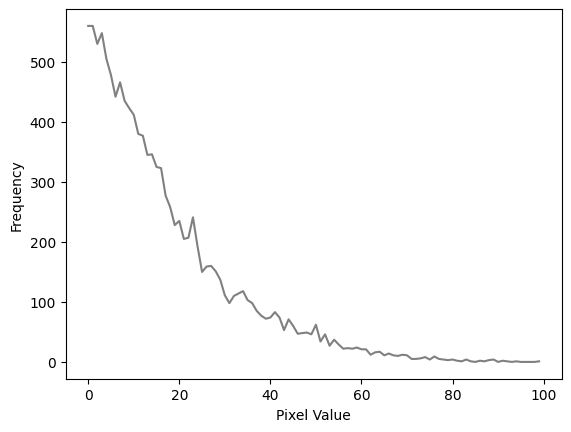

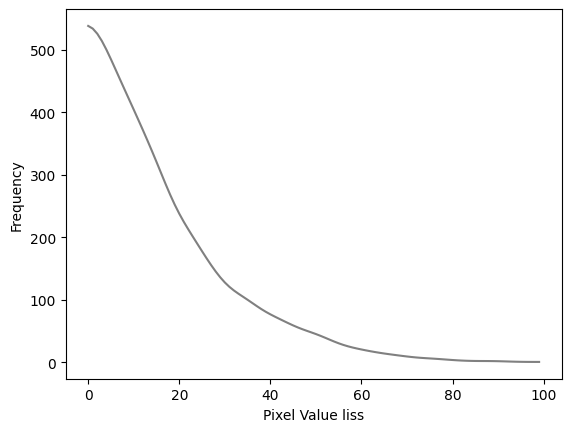

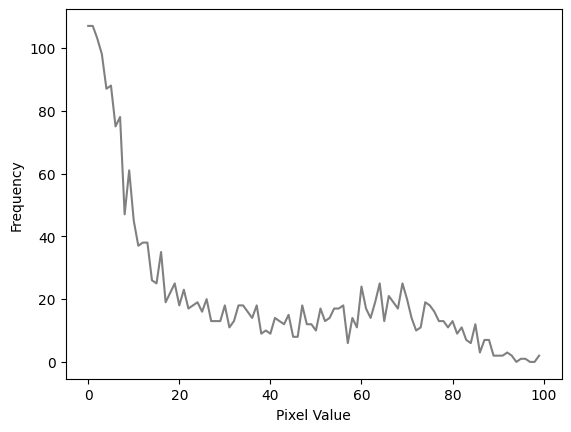

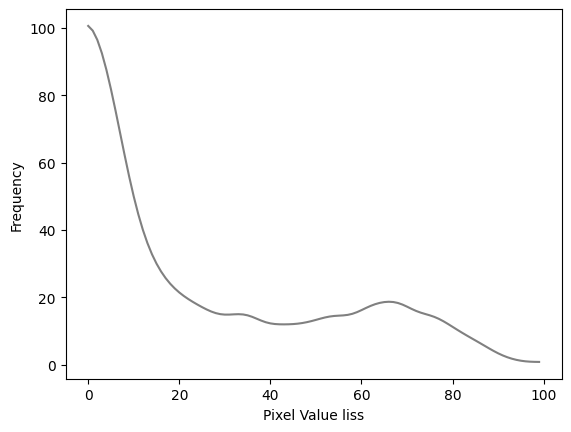

--------
0.11
0.2


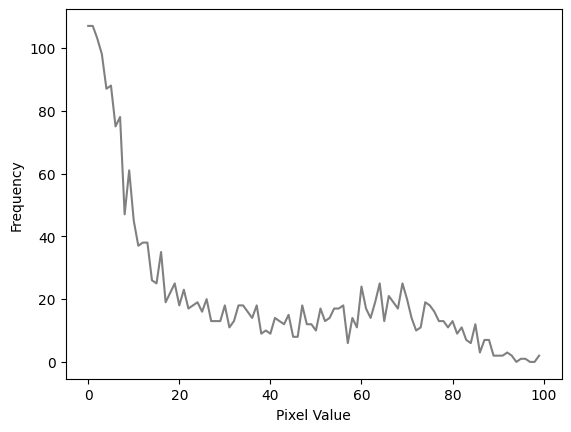

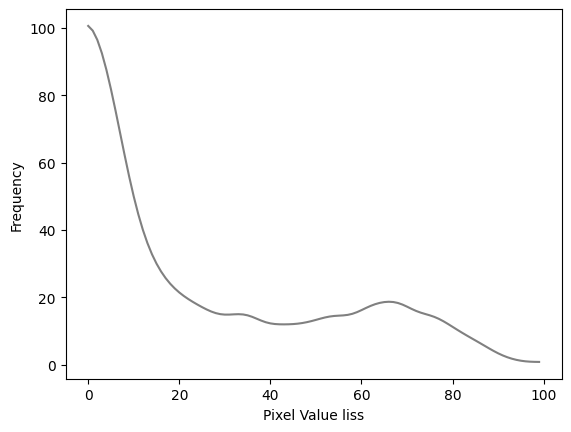

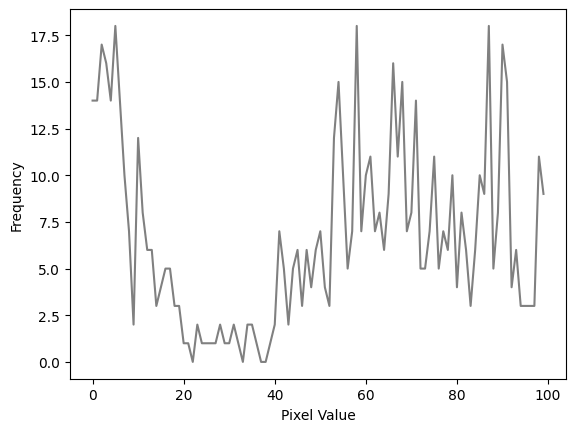

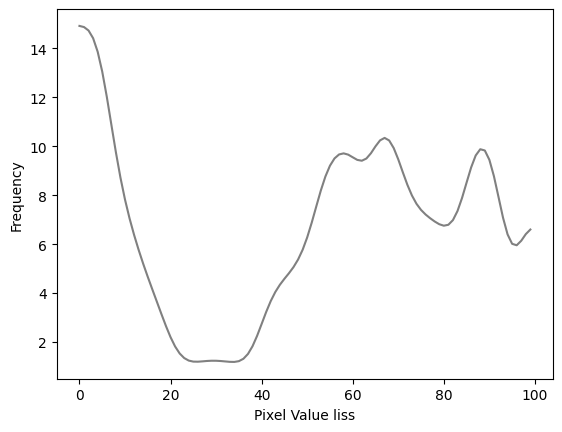

--------
0.03
0.23


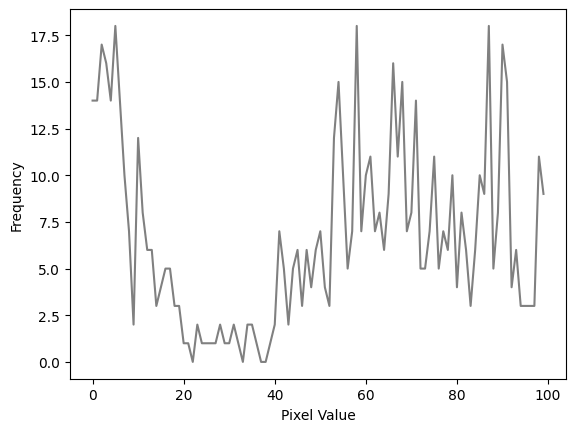

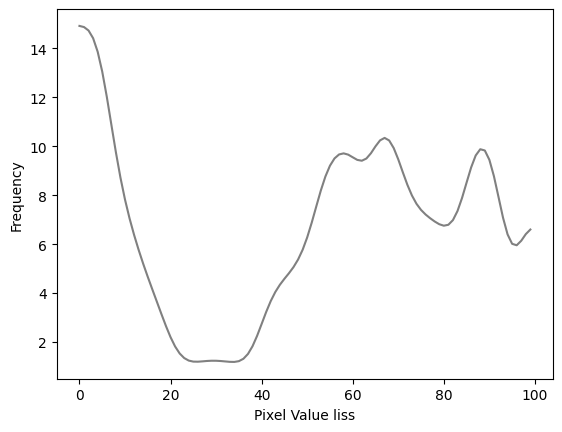

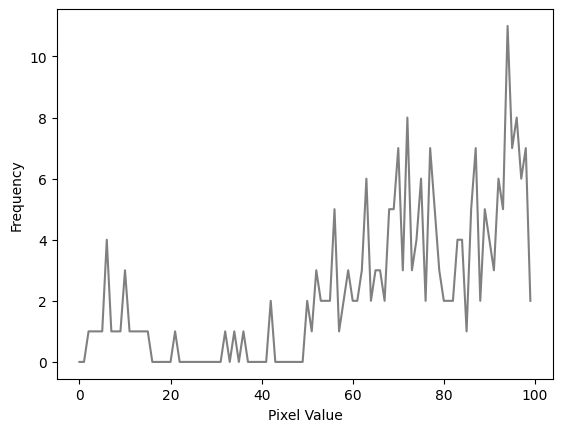

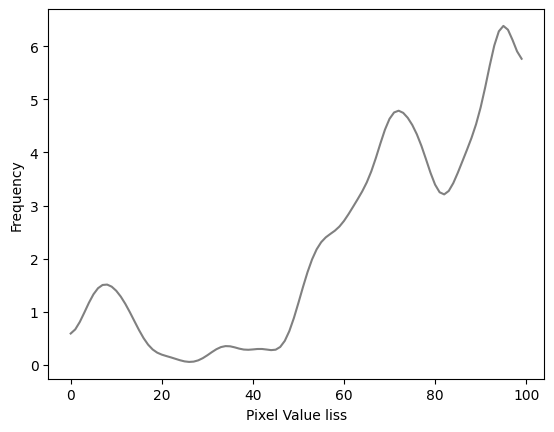

IndexError: index 0 is out of bounds for axis 0 with size 0

In [146]:
# Paramètres
N = 5  # Nombre d'échelles
alpha =0.01

# Tableau de matrices et calcul des images à plusieurs échelles
images_decimees = [None] * N
images_decimees[0] = image_normalized

for n in range(2, N + 1):
    images_decimees[n-1] = decim_im(image_normalized,  n)


# Détection de contours à chaque échelle
contours_binaires = [None] * N

for n in range(N):
    contours_binaires[n] = SingleScaleContourDetector(images_decimees[n] , 1  , alpha)

# Combine les contours à différentes échelles : de la plus grossière et en descendant progressivement
resultat_final = contours_binaires[N-1]

for n in range(N-2, -1, -1):
    # Dilatation du résultat actuel
    dto = dilat_morph(contours_binaires[n+1])
    
    # Convert b1 to the same data type as dto
    contours_binaires[n] = contours_binaires[n].astype(np.uint8)

   

    # Combinaison avec la carte de contours à l'échelle suivante
    resultat_final = cv2.bitwise_and(contours_binaires[n], dto)

    plt.imshow(resultat_final, cmap='gray')
    plt.title('Résultat de la détection de contours multiscale avec inhibition du contour, étape : ' + str(n+1))
    plt.show()

plt.imshow(resultat_final, cmap='gray')
plt.title('Résultat de la détection de contours multiscale avec inhibition du contour')
plt.show()

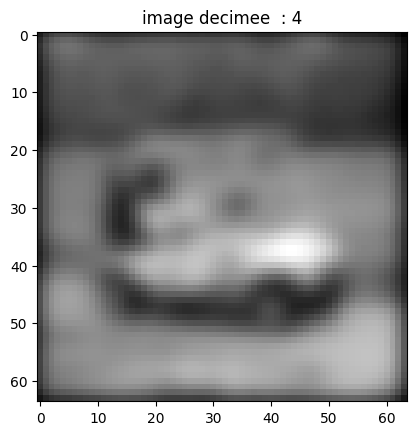

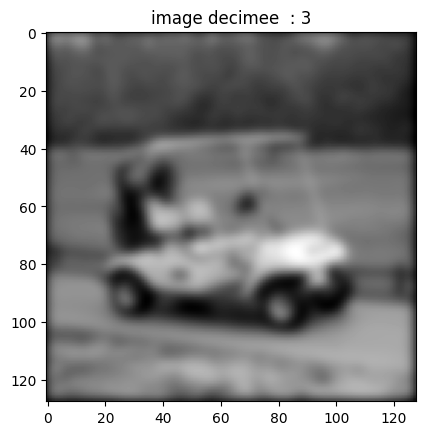

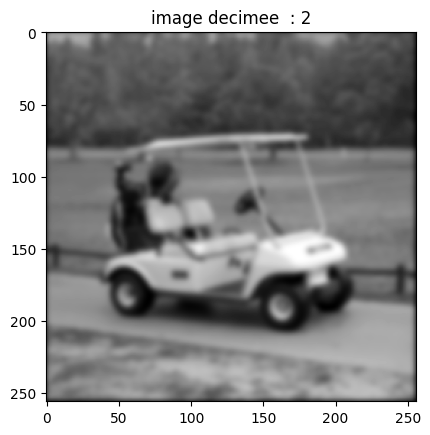

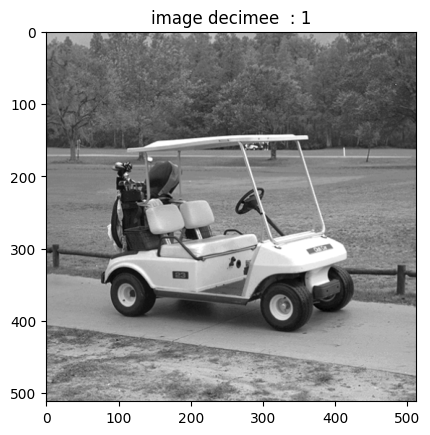

In [ ]:

for n in range(N-2, -1, -1):
    plt.imshow(images_decimees[n], cmap='gray')
    plt.title('image decimee  : ' + str(n+1))
    plt.show()

--------
0.32
0.48


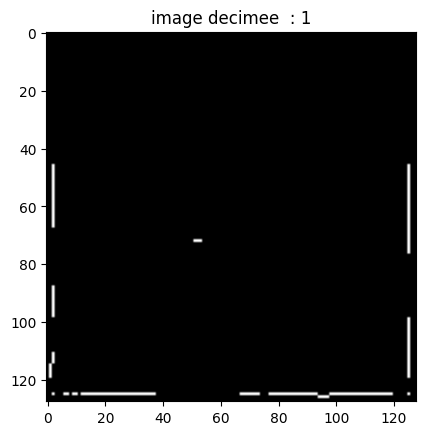

In [ ]:
b = SingleScaleContourDetector(images_decimees[2], 1  , alpha)

plt.imshow(b, cmap='gray')
plt.title('image decimee  : ' + str(n+1))
plt.show()